In [1]:
import numpy as np
import networkx as nx
from typing import Dict, Any, List
import random

In [2]:
RANDOM_SEED = 1
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [3]:
from optiLib.problem import TaskGraph, NetGraph

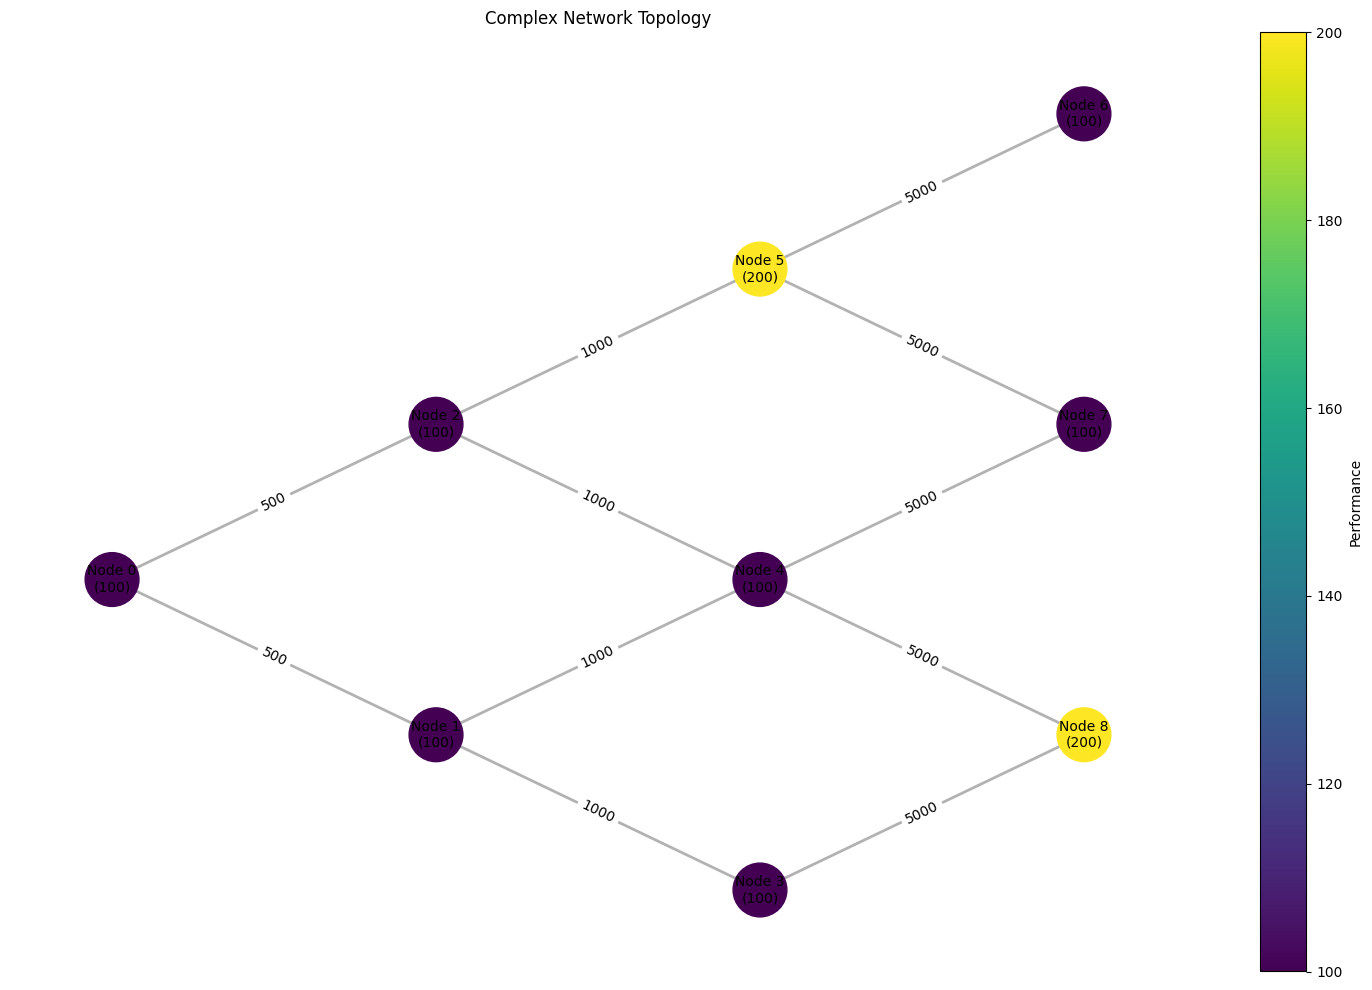


Network Properties:
Network type: Complex
Number of nodes: 9
Number of edges: 11

Nodes:
Node 0 - Performance: 100
Node 1 - Performance: 100
Node 2 - Performance: 100
Node 3 - Performance: 100
Node 4 - Performance: 100
Node 5 - Performance: 200
Node 6 - Performance: 100
Node 7 - Performance: 100
Node 8 - Performance: 200

Edge bandwidths:
Edge 0-2: 500
Edge 0-1: 500
Edge 1-4: 1000
Edge 1-3: 1000
Edge 2-4: 1000
Edge 2-5: 1000
Edge 3-8: 5000
Edge 4-7: 5000
Edge 4-8: 5000
Edge 5-6: 5000
Edge 5-7: 5000


In [4]:
# Создание сложной сети (первый пример)
net = NetGraph(graph_type=1)
net.visualize()
net.print_info()

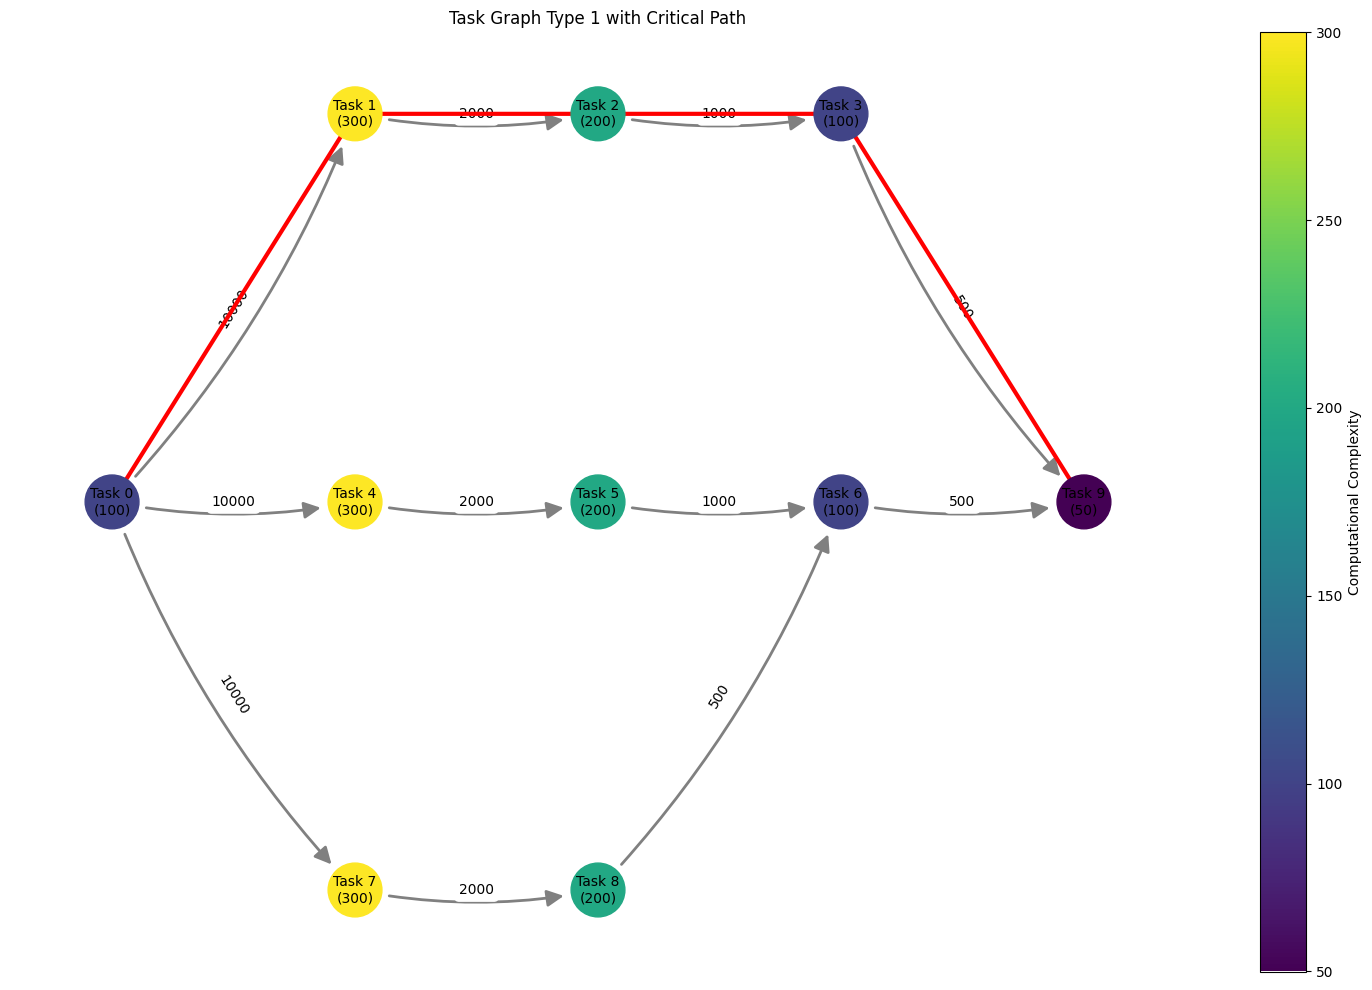


Task Graph Type 1 Properties:
Number of tasks: 10
Number of dependencies: 11
Total computational complexity: 1850
Total data transfer: 39500

Critical Path Information:
Path: 0 -> 1 -> 2 -> 3 -> 9
Length: 14250


In [5]:
task = TaskGraph(graph_type=1)
task.visualize()
task.print_info()

In [6]:
def calculate_resource_cost(vector: list, problem) -> dict:
    """
    Расчет стоимости привлекаемых ресурсов для решения задачи с учетом энергопотребления,
    назначений задач и нормализации критериев.
    
    Args:
        vector: list, распределение задач по узлам
        problem: объект задачи с информацией о платформе и задачах
        
    Returns:
        dict: результаты по стоимости ресурсов, нормализованным значениям и метрикам
    """
    # Проверяем наличие расписания и анализа
    if not hasattr(problem.scheduler, 'schedule') or not problem.scheduler.schedule:
        problem.scheduler.calculate_schedule(vector)
    
    # Получаем полный анализ системы и назначения задач
    analysis = problem.scheduler.get_complete_analysis(vector)
    node_assignments = problem.scheduler.assign_tasks_to_nodes(vector)
    
    nodes = problem.network_graph.nodes
    num_nodes = len(nodes)
    
    # Инициализация базовых параметров
    B = [0] * num_nodes  # Индикатор использования узлов
    C = [node.cost for node in nodes.values()]  # Базовая стоимость узлов
    C_operation = [node.operation_cost for node in nodes.values()]  # Стоимость операций
    
    # Расчет стоимости для каждого узла
    node_costs = {}
    total_C0 = 0  # Общая базовая стоимость
    total_C_operation = 0  # Общая стоимость операций
    
    for node_id, node in enumerate(nodes):
        node_info = analysis['nodes'][node_id]
        assigned_tasks = [task_id for task_id, assigned_node 
                         in node_assignments.items() if assigned_node == node_id]
        
        # Расчет стоимости вычислений
        computation_cost = 0
        for task_id in assigned_tasks:
            task_complexity = problem.task_graph.operations[task_id].get_task_complexity()
            computation_cost += task_complexity * C_operation[node_id]
            B[node_id] = 1
        
        # Расчет стоимости передачи данных
        transfer_cost = 0
        for transfer in analysis['transfers']:
            if transfer['from_node'] == node_id or transfer['to_node'] == node_id:
                B[node_id] = 1
                transfer_cost += transfer['data_volume'] * C_operation[node_id]
        
        # Расчет стоимости транзита
        transit_cost = 0
        for transfer in analysis['transfers']:
            src_node = transfer['from_node']
            dst_node = transfer['to_node']
            
            if src_node != node_id and dst_node != node_id:
                path = problem.scheduler.shortest_path(src_node, dst_node)
                if node_id in path[1:-1]:
                    B[node_id] = 1
                    transit_cost += transfer['data_volume'] * C_operation[node_id]
        
        # Расчет общей стоимости узла
        base_cost = C[node_id] * B[node_id]
        operation_cost = computation_cost + transfer_cost + transit_cost
        
        node_costs[node_id] = {
            'base_cost': base_cost,
            'computation_cost': computation_cost,
            'transfer_cost': transfer_cost,
            'transit_cost': transit_cost,
            'total_operation_cost': operation_cost
        }
        
        total_C0 += base_cost
        total_C_operation += operation_cost
    
    # Расчет максимально возможных стоимостей
    max_base_cost = sum(C)  # Максимальная базовая стоимость
    
    total_bandwidth = 0
    # Перебираем все рёбра в графе
    for u, v, data in problem.task_graph.graph.edges(data=True):
        # Добавляем bandwidth каждого ребра к общей сумме
        total_bandwidth += data['data_volume']    # Максимальная стоимость операций

    max_operation_cost = sum(
        problem.task_graph.operations[task_id].get_task_complexity() *  max(C_operation) 
        for task_id in problem.task_graph.operations
    ) + max(C_operation) * nx.diameter(problem.network_graph.graph) * total_bandwidth
    
    
    # Нормализация стоимостей
    C0_norm = total_C0 / max_base_cost if max_base_cost > 0 else 0
    C_operation_norm = total_C_operation / max_operation_cost if max_operation_cost > 0 else 0
    
    # Формирование результата
    result = {
        'node_costs': node_costs,        # Детальные затраты по узлам
        'C0': total_C0,                  # Общая базовая стоимость
        'C0_norm': C0_norm,              # Нормализованная базовая стоимость
        'total_C_operation': total_C_operation,  # Общая стоимость операций
        'C_operation_norm': C_operation_norm,    # Нормализованная стоимость операций
        'B': B,                          # Использование узлов
        'statistics': {
            'active_nodes': sum(B),      # Количество активных узлов
            'max_base_cost': max_base_cost,
            'max_operation_cost': max_operation_cost
        }
    }
    
    return result

# Пример использования:
'''
cost_analysis = calculate_resource_cost(vector, problem)

print("\nАнализ стоимости ресурсов:")
print(f"Общая базовая стоимость: {cost_analysis['C0']:.2f}")
print(f"Нормализованная базовая стоимость: {cost_analysis['C0_norm']:.2f}")
print(f"Общая стоимость операций: {cost_analysis['total_C_operation']:.2f}")
print(f"Нормализованная стоимость операций: {cost_analysis['C_operation_norm']:.2f}")
print(f"Активных узлов: {cost_analysis['statistics']['active_nodes']}")

print("\nДетальный анализ по узлам:")
for node_id, costs in cost_analysis['node_costs'].items():
    print(f"\nУзел {node_id}:")
    print(f"Базовая стоимость: {costs['base_cost']:.2f}")
    print(f"Стоимость вычислений: {costs['computation_cost']:.2f}")
    print(f"Стоимость передачи: {costs['transfer_cost']:.2f}")
    print(f"Стоимость транзита: {costs['transit_cost']:.2f}")
    print(f"Общая стоимость операций: {costs['total_operation_cost']:.2f}")
'''


'\ncost_analysis = calculate_resource_cost(vector, problem)\n\nprint("\nАнализ стоимости ресурсов:")\nprint(f"Общая базовая стоимость: {cost_analysis[\'C0\']:.2f}")\nprint(f"Нормализованная базовая стоимость: {cost_analysis[\'C0_norm\']:.2f}")\nprint(f"Общая стоимость операций: {cost_analysis[\'total_C_operation\']:.2f}")\nprint(f"Нормализованная стоимость операций: {cost_analysis[\'C_operation_norm\']:.2f}")\nprint(f"Активных узлов: {cost_analysis[\'statistics\'][\'active_nodes\']}")\n\nprint("\nДетальный анализ по узлам:")\nfor node_id, costs in cost_analysis[\'node_costs\'].items():\n    print(f"\nУзел {node_id}:")\n    print(f"Базовая стоимость: {costs[\'base_cost\']:.2f}")\n    print(f"Стоимость вычислений: {costs[\'computation_cost\']:.2f}")\n    print(f"Стоимость передачи: {costs[\'transfer_cost\']:.2f}")\n    print(f"Стоимость транзита: {costs[\'transit_cost\']:.2f}")\n    print(f"Общая стоимость операций: {costs[\'total_operation_cost\']:.2f}")\n'

In [7]:
def calculate_energy_consumption(vector: list, problem) -> dict:
    """
    Рассчитывает энергозатраты на решение задачи с учетом транзитных передач,
    используя vector распределения задач
    """
    # Проверяем наличие расписания и анализа
    if not hasattr(problem.scheduler, 'schedule') or not problem.scheduler.schedule:
        problem.scheduler.calculate_schedule(vector)

    analysis = problem.scheduler.get_complete_analysis(vector)
    node_assignments = problem.scheduler.assign_tasks_to_nodes(vector)
    
    results = {
        'node_energy': {},
        'total_energy': 0,
        'normalized_energy': {},
        'total_normalized_energy': 0,
        'transit_energy': {}
    }
    
    nodes = problem.network_graph.nodes
    task_graph = problem.task_graph.graph
    
    # Для каждого узла рассчитываем энергозатраты
    for node_id, node in nodes.items():
        node_info = analysis['nodes'][node_id]
        
        # Энергия на вычисления
        E_comp = 0
        assigned_tasks = [task_id for task_id, assigned_node 
                         in node_assignments.items() if assigned_node == node_id]
        
        for task_id in assigned_tasks:
            task_complexity = problem.task_graph.operations[task_id].get_task_complexity()
            E_comp += task_complexity * node.e_comp
        
        # Энергия на прием и отправку данных
        E_receive = 0
        E_send = 0
        E_transit = 0
        
        # Проходим по всем передачам данных
        for transfer in analysis['transfers']:
            src_node = transfer['from_node']
            dst_node = transfer['to_node']
            data_volume = transfer['data_volume']
            
            if src_node == node_id:
                # Узел является отправителем
                E_send += data_volume * node.e_send
            elif dst_node == node_id:
                # Узел является получателем
                E_receive += data_volume * node.e_receive
            else:
                # Проверяем, является ли узел транзитным на пути между src_node и dst_node
                src_task = transfer['from_task']
                dst_task = transfer['to_task']
                
                if vector[src_task] != node_id and vector[dst_task] != node_id:
                    path = problem.scheduler.shortest_path(src_node, dst_node)
                    if node_id in path[1:-1]:
                        E_transit += data_volume * (node.e_receive + node.e_send)
        
        E_total = E_comp + E_receive + E_send + E_transit
        
        results['node_energy'][node_id] = {
            'receive': E_receive,
            'compute': E_comp,
            'send': E_send,
            'transit': E_transit,
            'total': E_total
        }
        
        results['transit_energy'][node_id] = E_transit
    
    # Расчет максимальных возможных энергозатрат
    max_compute_energy = max(node.e_comp for node in nodes.values())
    max_receive_energy = max(node.e_receive for node in nodes.values())
    max_send_energy = max(node.e_send for node in nodes.values())
    
    total_operations = analysis['statistics']['total_operations']
    total_data = analysis['statistics']['total_data_transferred']
    network_diameter = nx.diameter(problem.network_graph.graph)
    
    E_max = (
        total_operations * max_compute_energy +
        total_data * network_diameter * (max_receive_energy + max_send_energy)
    )
    
    # Расчет общих энергозатрат
    results['total_energy'] = sum(
        node['total'] for node in results['node_energy'].values()
    )
    
    # Нормализация
    for node_id in results['node_energy']:
        results['normalized_energy'][node_id] = (
            results['node_energy'][node_id]['total'] / E_max if E_max > 0 else 0
        )
    
    results['total_normalized_energy'] = results['total_energy'] / E_max if E_max > 0 else 0
    
    return results

# Пример использования:
'''
# С учетом транзита
energy_with_transit = calculate_energy_consumption_with_transit(vector, problem)
print("\nЭнергозатраты с учетом транзита:")
for node_id, energy in energy_with_transit['node_energy'].items():
    print(f"\nУзел {node_id}:")
    print(f"Энергия вычислений: {energy['compute']:.2f}")
    print(f"Энергия приема: {energy['receive']:.2f}")
    print(f"Энергия отправки: {energy['send']:.2f}")
    print(f"Энергия транзита: {energy['transit']:.2f}")
    print(f"Общая энергия: {energy['total']:.2f}")
'''


'\n# С учетом транзита\nenergy_with_transit = calculate_energy_consumption_with_transit(vector, problem)\nprint("\nЭнергозатраты с учетом транзита:")\nfor node_id, energy in energy_with_transit[\'node_energy\'].items():\n    print(f"\nУзел {node_id}:")\n    print(f"Энергия вычислений: {energy[\'compute\']:.2f}")\n    print(f"Энергия приема: {energy[\'receive\']:.2f}")\n    print(f"Энергия отправки: {energy[\'send\']:.2f}")\n    print(f"Энергия транзита: {energy[\'transit\']:.2f}")\n    print(f"Общая энергия: {energy[\'total\']:.2f}")\n'

In [8]:
def calculate_reliability_and_load_balancing(vector: List[int],  problem: Any, tau: float = 1, k: float = 1) -> Dict[str, Any]:
    """
    Расчет надежности системы и балансировки нагрузки на основе временных характеристик
    """    
    # Проверяем наличие расписания и анализа
    if not hasattr(problem.scheduler, 'schedule') or not problem.scheduler.schedule:
        problem.scheduler.calculate_schedule(vector)
    # Получаем полный анализ системы
    analysis = problem.scheduler.get_complete_analysis(vector)
    
    num_nodes = len(problem.scheduler.net_graph.nodes)
    nodes = problem.scheduler.net_graph.nodes
    
    # Получаем общее время выполнения всех задач
    total_time = analysis['statistics']['total_time']
    
    # Расчет нагрузки и надежности для каждого узла
    node_loads = np.zeros(num_nodes)  # D_i
    node_reliability = np.zeros(num_nodes)  # P_i
    node_metrics = []
    
    for node_id in range(num_nodes):
        node_info = analysis['nodes'][node_id]
        
        # Времена для каждого типа операций
        compute_time = node_info['working_time']     # время вычислений
        send_time = node_info['send_time']          # время отправки
        receive_time = node_info['receive_time']     # время приема
        
        # Общее активное время узла
        active_time = compute_time + send_time + receive_time
        
        # Время простоя
        idle_time = total_time - active_time
        
        # Расчет загруженности узла (D_i)
        # D_i = общее активное время узла / общее время выполнения задачи
        node_loads[node_id] = active_time / total_time if total_time > 0 else 0
        
        # Расчет надежности узла (P_i)
        lambda_0i = nodes[node_id].failure_rate
        Di = node_loads[node_id]
        node_reliability[node_id] = np.exp(-lambda_0i * tau * (2 ** (k * Di / 10)))
        
        # Сохраняем метрики узла
        node_metrics.append({
            'node_id': node_id,
            'compute_time': compute_time,
            'send_time': send_time,
            'receive_time': receive_time,
            'active_time': active_time,
            'idle_time': idle_time,
            'load': Di,
            'reliability': node_reliability[node_id]
        })
    
    # Общая надежность системы (произведение надежностей всех узлов)
    P0 = np.prod(node_reliability)
    
    data_array = np.array(node_loads)
    
    # Фильтруем значения меньше 0.0001 (считаем их нулевой нагрузкой)
    non_zero_data = data_array[data_array >= 0.0001]
    
    if non_zero_data.size == 0:
        return {"message": "Нет значений для анализа"}
    
    # Вычисляем статистики
    mean_val = np.mean(non_zero_data)
    variance_val = np.var(non_zero_data)
    std_dev_val = np.std(non_zero_data)

    # Максимально возможное стандартное отклонение для диапазона [0.0001, 1]
    max_std = 0.5

    # Нормализация (0 = одинаковые значения, 1 = максимальный разброс)
    normalized_dispersion = std_dev_val / max_std

    # Ограничиваем значения в диапазоне [0, 1]
    normalized_dispersion = np.clip(normalized_dispersion, 0, 1)

    # Формирование результата
    result = {
        "P_0": float(P0),                    # Общая надежность системы
        "D": node_loads.tolist(),            # Загруженность узлов
        "Δ": float(normalized_dispersion)+0.000000000001,          # Коэффициент вариации нагрузки
        "detailed_analysis": {
            "total_time": total_time,        # Общее время выполнения
            "node_metrics": node_metrics,     # Детальные метрики по узлам
            "system_metrics": {
                "mean_load": float(mean_val),
                "std_load": float(std_dev_val),
                "min_load": float(np.min(node_loads)),
                "max_load": float(np.max(node_loads)),
                "node_reliability": node_reliability.tolist()
            }
        }
    }
    
    return result

# Пример использования:
'''
result = calculate_reliability_and_load_balancing(
    vector, 
    problem, 
    tau=1.0, 
    k=2.0
)

print(f"Общая надежность системы (P0): {result['P_0']:.4f}")
print(f"Коэффициент вариации нагрузки (Δ): {result['Δ']:.4f}")
print("\nДетальный анализ по узлам:")
for metrics in result['detailed_analysis']['node_metrics']:
    print(f"\nУзел {metrics['node_id']}:")
    print(f"Время вычислений: {metrics['compute_time']:.2f}")
    print(f"Время передачи: {metrics['send_time']:.2f}")
    print(f"Время приема: {metrics['receive_time']:.2f}")
    print(f"Время простоя: {metrics['idle_time']:.2f}")
    print(f"Загруженность (Di): {metrics['load']:.2%}")
    print(f"Надежность узла (Pi): {metrics['reliability']:.4f}")
'''


'\nresult = calculate_reliability_and_load_balancing(\n    vector, \n    problem, \n    tau=1.0, \n    k=2.0\n)\n\nprint(f"Общая надежность системы (P0): {result[\'P_0\']:.4f}")\nprint(f"Коэффициент вариации нагрузки (Δ): {result[\'Δ\']:.4f}")\nprint("\nДетальный анализ по узлам:")\nfor metrics in result[\'detailed_analysis\'][\'node_metrics\']:\n    print(f"\nУзел {metrics[\'node_id\']}:")\n    print(f"Время вычислений: {metrics[\'compute_time\']:.2f}")\n    print(f"Время передачи: {metrics[\'send_time\']:.2f}")\n    print(f"Время приема: {metrics[\'receive_time\']:.2f}")\n    print(f"Время простоя: {metrics[\'idle_time\']:.2f}")\n    print(f"Загруженность (Di): {metrics[\'load\']:.2%}")\n    print(f"Надежность узла (Pi): {metrics[\'reliability\']:.4f}")\n'

In [9]:
def calculate_migration_metrics(vector: list, problem) -> dict:
    '''
    Рассчитывает метрики миграции задач с нулевого узла согласно вектору распределения
    
    Args:
        vector (list): Вектор распределения задач по узлам (индекс = id задачи, значение = id узла)
        problem (Problem): Объект задачи с информацией о сети и задачах
        
    Returns:
        dict: Метрики миграции:
            - M_total: Общие затраты на миграцию
            - M_norm: Нормализованные затраты [0,1]
            - migration_paths: Информация о путях миграции
            - migration_tasks: Информация о миграции задач
            - migration_stats: Статистика миграции
    '''
    # Проверяем наличие расписания и анализа
    if not hasattr(problem.scheduler, 'schedule') or not problem.scheduler.schedule:
        problem.scheduler.calculate_schedule(vector)
        
    # Получаем граф сети
    network = problem.network_graph.graph
    
    # Рассчитываем кратчайшие пути от нулевого узла
    shortest_paths = nx.single_source_dijkstra_path(
        network, 
        source=0,
        weight='weight'
    )
    shortest_paths_lengths = nx.single_source_dijkstra_path_length(
        network,
        source=0,
        weight='weight'  
    )
    
    M_total = 0  # Общие затраты на миграцию
    migration_paths = {}  # Информация о путях к каждому узлу
    migration_tasks = {}  # Информация о миграции задач
    
    # Группируем задачи по узлам назначения
    nodes_tasks = {}
    for task_id, node_id in enumerate(vector):
        if node_id != 0:
            if node_id not in nodes_tasks:
                nodes_tasks[node_id] = []
            nodes_tasks[node_id].append(task_id)
    
    # Для каждого узла назначения
    for node_id, tasks in nodes_tasks.items():
        node_migration_cost = 0
        node_tasks = []
        path_length = shortest_paths_lengths[node_id]
        
        # Обрабатываем каждую задачу для этого узла
        for task_id in tasks:
            task = problem.task_graph.operations[task_id]
            task_volume = task.get_task_complexity()
            
            # Стоимость миграции задачи
            task_migration_cost = path_length * task_volume
            node_migration_cost += task_migration_cost
            
            # Сохраняем информацию о миграции задачи
            task_info = {
                'target_node': node_id,
                'path': shortest_paths[node_id],
                'volume': task_volume,
                'migration_cost': task_migration_cost
            }
            migration_tasks[task_id] = task_info
            
            node_tasks.append({
                'task_id': task_id,
                'volume': task_volume,
                'migration_cost': task_migration_cost
            })
            
        if node_tasks:
            migration_paths[node_id] = {
                'path': shortest_paths[node_id],
                'length': path_length,
                'total_node_cost': node_migration_cost,
                'tasks': node_tasks
            }
            M_total += node_migration_cost
    
    # Нормализация
    max_path_length = max(shortest_paths_lengths.values())
    total_task_volume = sum(task.get_task_complexity() 
                           for task in problem.task_graph.operations.values())
    max_possible_migration_cost = max_path_length * total_task_volume
    
    M_norm = M_total / max_possible_migration_cost if max_possible_migration_cost > 0 else 0
    
    # Собираем статистику
    migrated_task_count = len(migration_tasks)
    total_migrated_volume = sum(info['volume'] for info in migration_tasks.values())
    migration_lengths = [info['length'] for info in migration_paths.values()]
    
    return {
        'M_total': float(M_total),  # Общие затраты на миграцию
        'M_norm': float(M_norm),    # Нормализованные затраты
        'migration_paths': migration_paths,  # Информация о путях миграции
        'migration_tasks': migration_tasks,  # Информация о задачах
        'migration_stats': {
            'migrated_task_count': migrated_task_count,
            'total_migrated_volume': float(total_migrated_volume),
            'max_migration_path': float(max(migration_lengths)) if migration_lengths else 0,
            'avg_migration_path': float(np.mean(migration_lengths)) if migration_lengths else 0,
            'migration_paths_count': len(migration_paths),
            'max_possible_cost': float(max_possible_migration_cost)
        }
    }

'''
migration_metrics = calculate_migration_metrics(vector, problem)

print(f"M_total (общие затраты): {migration_metrics['M_total']:.2f}")
print(f"M_norm (нормализованные затраты): {migration_metrics['M_norm']:.4f}")

print("\nСтатистика миграции:")
stats = migration_metrics['migration_stats']
print(f"Количество задач: {stats['migrated_task_count']}")
print(f"Общий объем: {stats['total_migrated_volume']:.2f}")
print(f"Макс. длина пути: {stats['max_migration_path']}")
print(f"Средняя длина пути: {stats['avg_migration_path']:.2f}")

print("\nПути миграции:")
for node_id, info in migration_metrics['migration_paths'].items():
    print(f"\nУзел {node_id}:")
    print(f"Путь: {info['path']}")
    print(f"Длина: {info['length']}")
    print(f"Стоимость: {info['total_node_cost']:.2f}")
    print("Задачи:")
    for task in info['tasks']:
        print(f"  Задача {task['task_id']}: "
              f"объем={task['volume']}, "
              f"стоимость={task['migration_cost']:.2f}")
'''

'\nmigration_metrics = calculate_migration_metrics(vector, problem)\n\nprint(f"M_total (общие затраты): {migration_metrics[\'M_total\']:.2f}")\nprint(f"M_norm (нормализованные затраты): {migration_metrics[\'M_norm\']:.4f}")\n\nprint("\nСтатистика миграции:")\nstats = migration_metrics[\'migration_stats\']\nprint(f"Количество задач: {stats[\'migrated_task_count\']}")\nprint(f"Общий объем: {stats[\'total_migrated_volume\']:.2f}")\nprint(f"Макс. длина пути: {stats[\'max_migration_path\']}")\nprint(f"Средняя длина пути: {stats[\'avg_migration_path\']:.2f}")\n\nprint("\nПути миграции:")\nfor node_id, info in migration_metrics[\'migration_paths\'].items():\n    print(f"\nУзел {node_id}:")\n    print(f"Путь: {info[\'path\']}")\n    print(f"Длина: {info[\'length\']}")\n    print(f"Стоимость: {info[\'total_node_cost\']:.2f}")\n    print("Задачи:")\n    for task in info[\'tasks\']:\n        print(f"  Задача {task[\'task_id\']}: "\n              f"объем={task[\'volume\']}, "\n              f"стои

In [10]:
def convert_vector_to_tuple(vector):
    """
    Конвертирует numpy array в tuple для хэширования
    """
    if isinstance(vector, np.ndarray):
        return tuple(vector.flatten())
    return tuple(vector)

# CASE 2: С учетом транзита
def case_2_f1_cost(vector, problem) -> float:
    """
    Критерий оптимизации f1 - стоимость (с транзитом)
    """
    vector_tuple = convert_vector_to_tuple(vector)
    cost_analysis = calculate_resource_cost(vector_tuple, problem)
    return float(cost_analysis['C0'] + cost_analysis['total_C_operation'])

def case_2_f2_total_energy(vector, problem) -> float:
    """
    Критерий оптимизации f2 - энергопотребление (с транзитом)
    """
    vector_tuple = convert_vector_to_tuple(vector)
    energy = calculate_energy_consumption(vector_tuple, problem)
    return float(energy['total_energy'])

def case_2_f3_M_total(vector, problem) -> float:
    """
    Критерий оптимизации f3 - общее время выполнения (с транзитом)
    """
    vector_tuple = convert_vector_to_tuple(vector)
    analysis = problem.scheduler.get_complete_analysis(vector_tuple)
    return float(analysis['statistics']['total_time'])

def case_2_f4_reliability(vector, problem) -> float:
    """
    Критерий оптимизации f4 - надежность (без нормализации)
    """
    vector_tuple = convert_vector_to_tuple(vector)
    reliability = calculate_reliability_and_load_balancing(vector_tuple, problem)
    return float(reliability['P_0'])

def case_2_f5_load_balance(vector, problem, max_variation=1.0) -> float:
    """
    Критерий оптимизации f5 - нормализованная балансировка нагрузки
    """
    vector_tuple = convert_vector_to_tuple(vector)
    load_balance = calculate_reliability_and_load_balancing(vector_tuple, problem)
    return float(load_balance['Δ'] / max_variation)

In [11]:
def c1_time_limit(vector, problem):
    """
    Проверка на ограничение по времени
    """
    # Проверяем наличие расписания и анализа
    if not hasattr(problem.scheduler, 'schedule') or not problem.scheduler.schedule:
        problem.scheduler.calculate_schedule(vector)

    analysis = problem.scheduler.get_complete_analysis(vector)
    time = analysis['statistics']['total_time']
    return bool(time <= problem.t_lim)

def c2_Di(vector, problem):
    """
    Проверка на ограничение на первый узел 
    """
    analysis = calculate_reliability_and_load_balancing(vector, problem)
    D =  analysis['D']
    return all(di < 0.75 for di in D)

In [12]:
from optiLib import NetworkOptimizationProblem

problem = NetworkOptimizationProblem(net, task, f_objective=[case_2_f1_cost, case_2_f2_total_energy, case_2_f3_M_total, case_2_f4_reliability, case_2_f5_load_balance], constraints=[c1_time_limit, c2_Di], t_lim=500, name="CASE2")

In [13]:
from IPython.display import clear_output
import random

for exp in range(0, 0):
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import RandomSearchOptimizer, ParticleSwarmOptimizer

    # Инициализация оптимизатора
    optimizer = ParticleSwarmOptimizer(problem, inertia = 1.7,cognitive = 2.5 , social = 1.5, num_particles=100, iterations=1000, update_history_coef = 100)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    print(len(optimizer.history))
    if len(optimizer.history)>0:
        optimizer.save(exp)
    
    clear_output(wait=True)

In [14]:
# Нормализованные версии CASE 2
def case_2_f1_cost_norm(vector, problem) -> float:
    """
    Нормализованный критерий оптимизации f1 - стоимость (без транзита)
    """
    vector_tuple = convert_vector_to_tuple(vector)
    cost_analysis = calculate_resource_cost(vector_tuple, problem)
    return float((cost_analysis['C0_norm'] + cost_analysis['C_operation_norm']) / 2)

def case_2_f2_total_energy_norm(vector, problem) -> float:
    """
    Критерий оптимизации f2 - энергопотребление (без транзита)
    """
    vector_tuple = convert_vector_to_tuple(vector)
    reliability_analysis = calculate_energy_consumption(vector_tuple, problem)
    return float(reliability_analysis['total_normalized_energy'])

def case_2_f3_M_total_norm(vector, problem) -> float:
    """
    Нормализованный критерий оптимизации f3 - общее время выполнения (без транзита)
    """
    vector_tuple = convert_vector_to_tuple(vector)
    migration = calculate_migration_metrics(vector_tuple, problem)
    return float(migration['M_norm'])

def case_2_f4_reliability_norm(vector, problem, max_reliability=1.0) -> float:
    """
    Критерий оптимизации f4 - нормализованная надежность
    """
    vector_tuple = convert_vector_to_tuple(vector)
    reliability = calculate_reliability_and_load_balancing(vector_tuple, problem)
    return float(reliability['P_0'] / max_reliability)

def case_2_f5_load_balance_norm(vector, problem, max_variation=1.0) -> float:
    """
    Критерий оптимизации f5 - нормализованная балансировка нагрузки
    """
    vector_tuple = convert_vector_to_tuple(vector)
    load_balance = calculate_reliability_and_load_balancing(vector_tuple, problem)
    return float(load_balance['Δ'] / max_variation)

In [ ]:
from optiLib import NetworkOptimizationProblem

problem_norm = NetworkOptimizationProblem(net, task, f_objective=[case_2_f1_cost_norm, case_2_f2_total_energy_norm, case_2_f4_reliability_norm], constraints=[c1_time_limit, c2_Di], t_lim=500, name="CASE2_norm_no_MiG_and_LB")

In [ ]:
from IPython.display import clear_output
import random

for exp in range(0, 20):
    print(f"Эксперемент {exp}")
    RANDOM_SEED = exp
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    from optiLib.optimizers import RandomSearchOptimizer, ParticleSwarmOptimizer

    # Инициализация оптимизатора
    optimizer = ParticleSwarmOptimizer(problem_norm, inertia = 1.7,cognitive = 2.5 , social = 1.5, num_particles=100, iterations=1000, update_history_coef = 100)

    # Запуск оптимизации
    best_solution, best_value = optimizer.optimize()

    from optiLib.helpers import print_solution
    print_solution(best_solution, best_value)
    print(len(optimizer.history))
    if len(optimizer.history)>0:
        optimizer.save(exp)
    
    clear_output(wait=True)

Эксперемент 12


Optimizing:   8%|▊         | 78/1000 [00:03<00:42, 21.89it/s]c:\Users\meon4\Documents\MATH\Новые расчеты\optiLib\optimizers.py:113: RuntimeWarning: invalid value encountered in cast
  self.position += self.velocity.astype(self.problem.dtype)
Optimizing:  14%|█▍        | 143/1000 [00:05<00:15, 53.87it/s]

In [ ]:
1/0

ZeroDivisionError: division by zero

In [ ]:
problem_norm.network_graph.nodes

{0: NetworkNode(id=0, performance=100, e_receive=0.2668088018810296, e_comp=0.6321946960652949, e_send=0.10004574992693796, cost=92.09330290527359, operation_cost=25.103184017324544, failure_rate=0.0),
 1: NetworkNode(id=1, performance=100, e_receive=0.17450408455106836, e_comp=0.4073364362258287, e_send=0.258706989692268, cost=101.55266936013427, operation_cost=85.66072637610664, failure_rate=0.0),
 2: NetworkNode(id=2, performance=100, e_receive=0.18178089989260698, e_comp=0.7268704618345674, e_send=0.11095503727917047, cost=106.81870040713608, operation_cost=73.3593826323603, failure_rate=0.0),
 3: NetworkNode(id=3, performance=100, e_receive=0.15615477543809353, e_comp=0.3188608934509273, e_send=0.4202978274702147, cost=118.7304630287759, operation_cost=82.57282855230756, failure_rate=0.0),
 4: NetworkNode(id=4, performance=100, e_receive=0.45055566091841537, e_comp=0.7367639981023084, e_send=0.1340176845479112, cost=81.5621913293153, operation_cost=93.57545602266553, failure_rate=

In [ ]:
problem_norm.convolution_evaluate_objectives([0,0,0,0,0,0,0,0,0,8])

np.float64(0.0011104445042964001)

In [ ]:
problem_norm.evaluate_objectives([0,0,0,0,0,0,0,0,0,8])

[0.40148624971907454,
 0.1525385160251866,
 0.02702702702702703,
 1.0,
 0.6708854763403158]

In [ ]:
problem_norm.evaluate([0,0,0,0,0,0,0,0,0,8])

inf

In [ ]:
solution = [8, 8, 8, 8, 8, 8, 8, 8, 3, 8]
solution = [0,0,0,0,2,0,0,0,0,0]


In [ ]:
result = calculate_reliability_and_load_balancing(
    solution, 
    problem_norm, 
)

print(f"Общая надежность системы (P0): {result['P_0']:.4f}")
print(f"Коэффициент вариации нагрузки (Δ): {result['Δ']:.4f}")

print("\nДетальный анализ по узлам:")
for metrics in result['detailed_analysis']['node_metrics']:
    print(f"\nУзел {metrics['node_id']}:")
    print(f"Время вычислений: {metrics['compute_time']:.2f}")
    print(f"Время отправки: {metrics['send_time']:.2f}")
    print(f"Время приема: {metrics['receive_time']:.2f}")
    print(f"Общее активное время: {metrics['active_time']:.2f}")
    print(f"Время простоя: {metrics['idle_time']:.2f}")
    print(f"Загруженность (Di): {metrics['load']:.2%}")
    print(f"Надежность узла (Pi): {metrics['reliability']:.4f}")

Общая надежность системы (P0): 1.0000
Коэффициент вариации нагрузки (Δ): 0.0447

Детальный анализ по узлам:

Узел 0:
Время вычислений: 15.50
Время отправки: 100.00
Время приема: 20.00
Общее активное время: 135.50
Время простоя: 144.00
Загруженность (Di): 48.48%
Надежность узла (Pi): 1.0000

Узел 1:
Время вычислений: 0.00
Время отправки: 0.00
Время приема: 0.00
Общее активное время: 0.00
Время простоя: 279.50
Загруженность (Di): 0.00%
Надежность узла (Pi): 1.0000

Узел 2:
Время вычислений: 3.00
Время отправки: 20.00
Время приема: 100.00
Общее активное время: 123.00
Время простоя: 156.50
Загруженность (Di): 44.01%
Надежность узла (Pi): 1.0000

Узел 3:
Время вычислений: 0.00
Время отправки: 0.00
Время приема: 0.00
Общее активное время: 0.00
Время простоя: 279.50
Загруженность (Di): 0.00%
Надежность узла (Pi): 1.0000

Узел 4:
Время вычислений: 0.00
Время отправки: 0.00
Время приема: 0.00
Общее активное время: 0.00
Время простоя: 279.50
Загруженность (Di): 0.00%
Надежность узла (Pi): 1.0000

In [ ]:
solution = problem.generate_random_solution()
solution

In [ ]:
solution = [0,0,0,0,0,0,0,0,0,8]

In [ ]:
problem.scheduler.calculate_schedule(solution)

In [ ]:
problem.scheduler.data_transfers

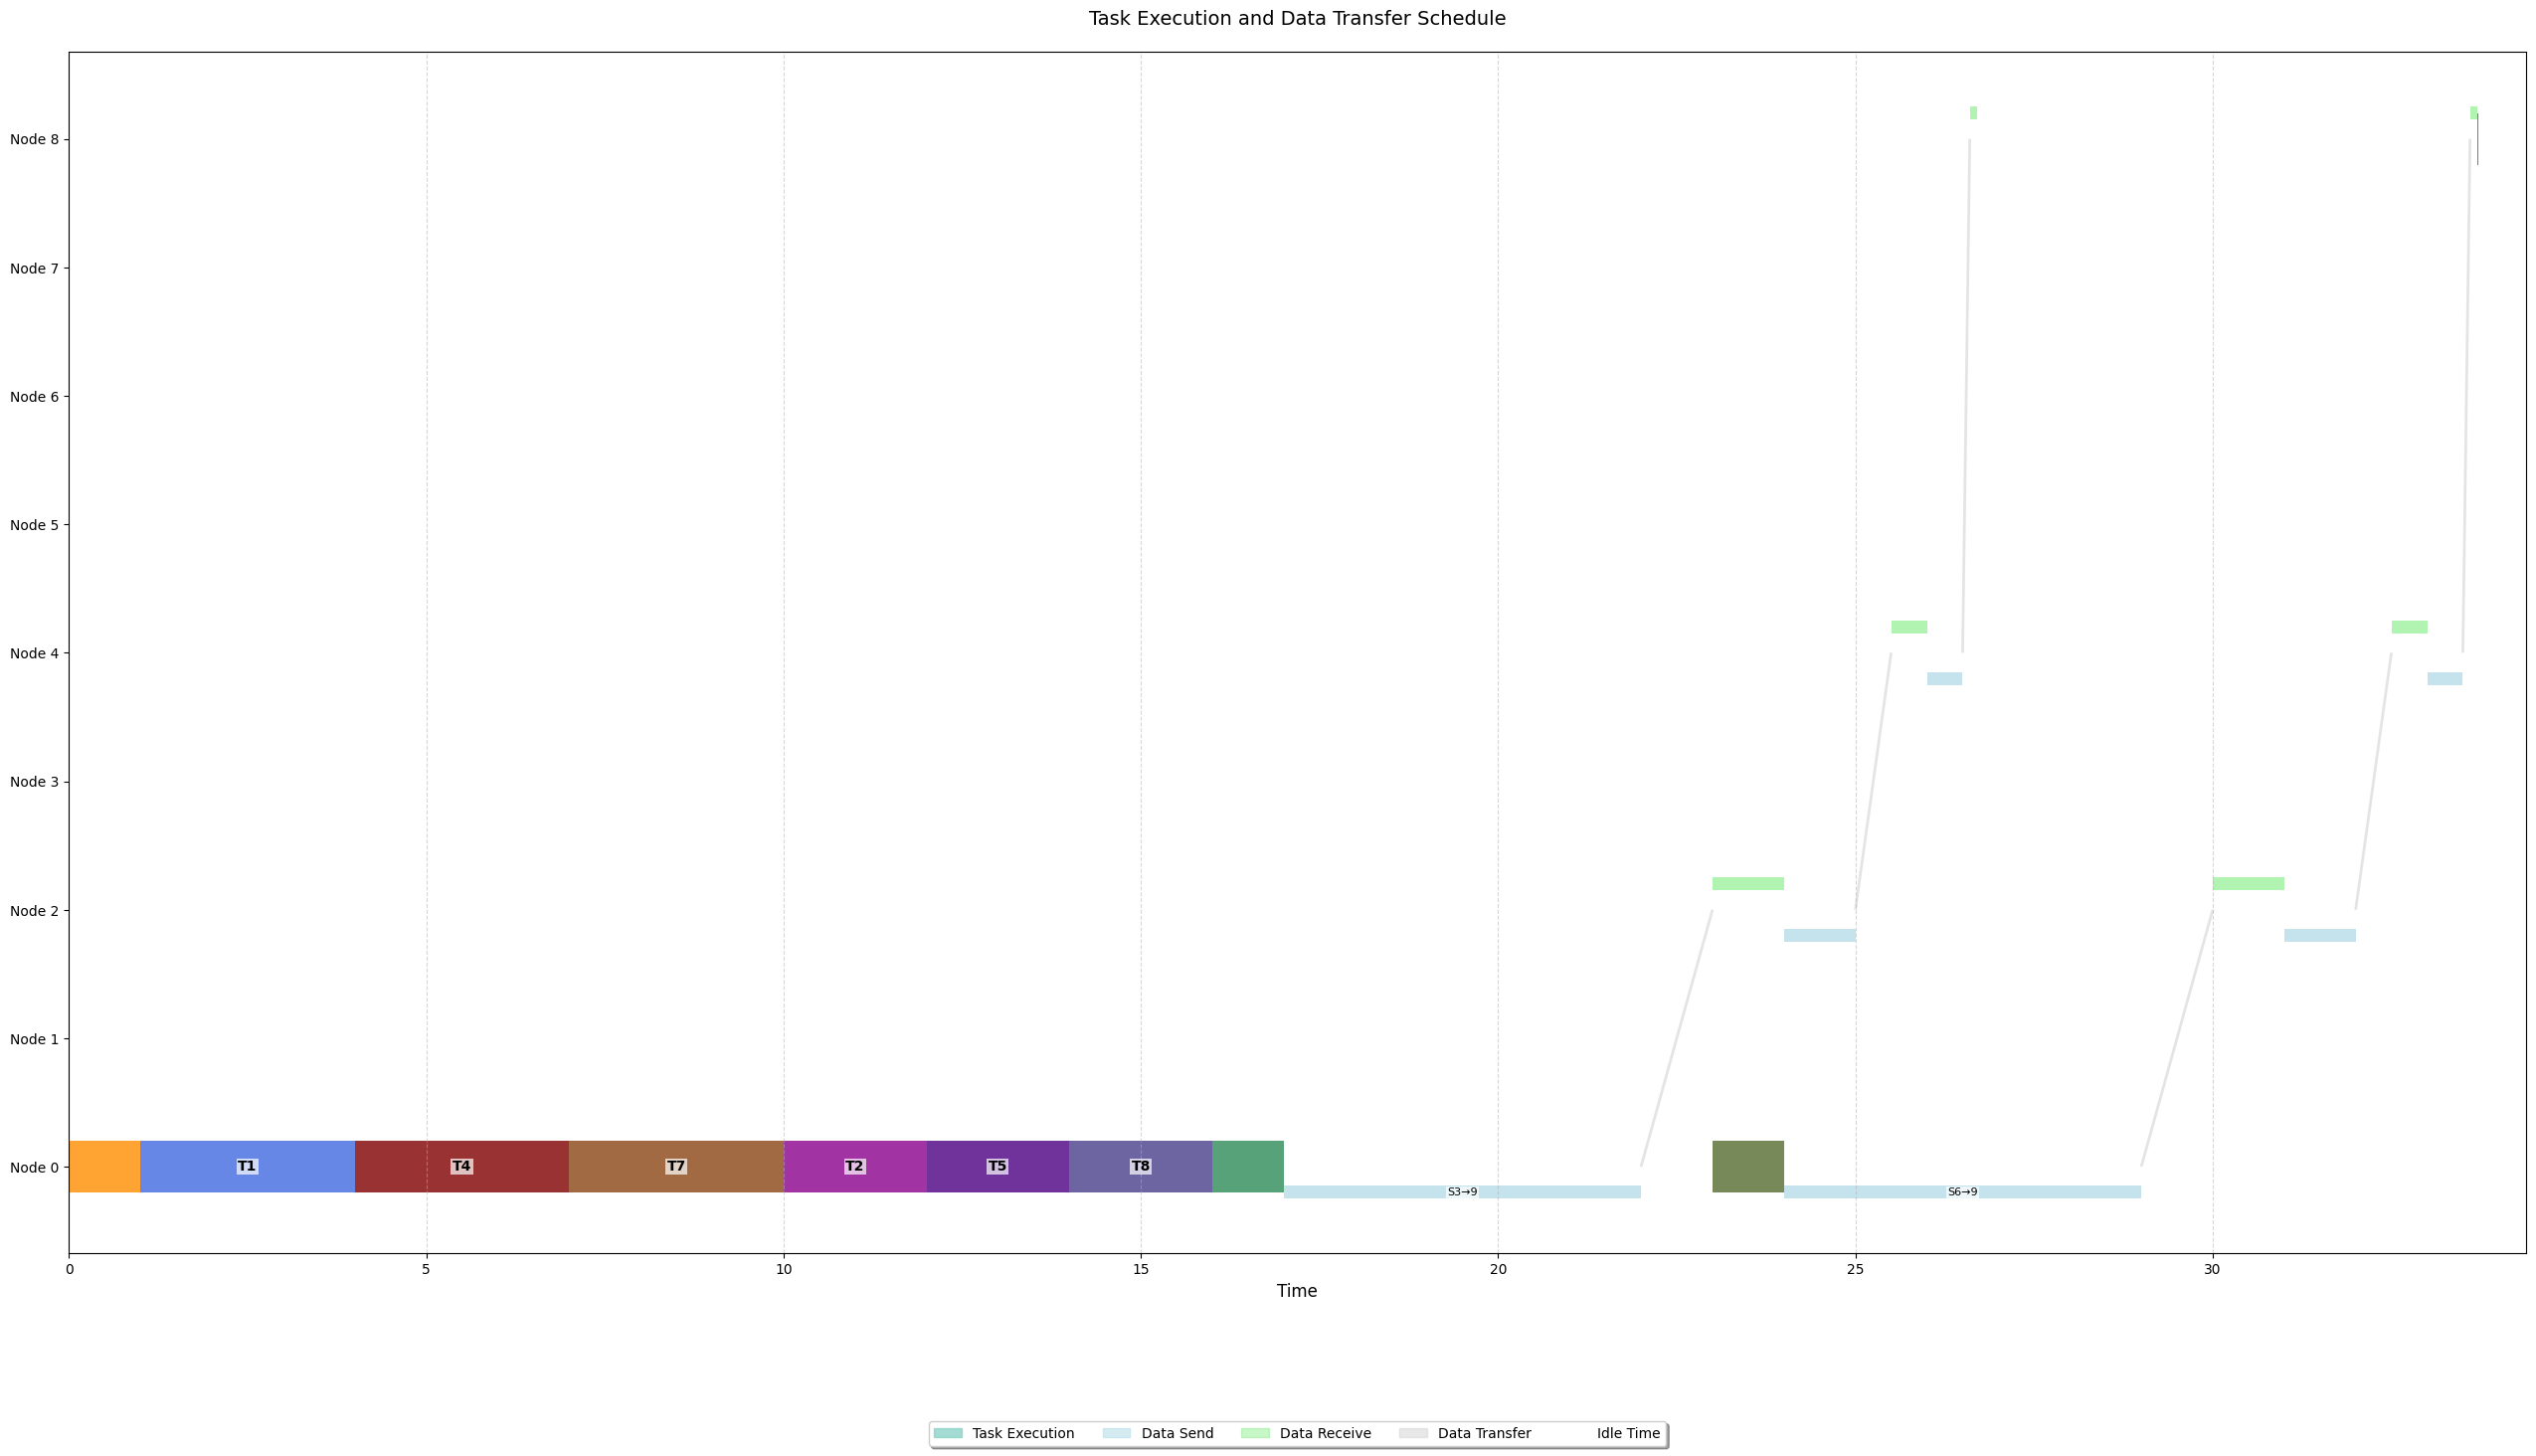

In [ ]:
problem.scheduler.calculate_schedule(solution)
problem.scheduler.create_gantt_chart()